# N2200 in situ blade coating

### Import python libraries

In [1]:
# numpy and plotting
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Data handling
import os
import glob
import pandas as pd

# pyFAI
import pyFAI
import pygix
import fabio
from pygix import plotting as ppl

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True,
                 'xtick.top': True,
                 'xtick.direction': 'in',
                 'ytick.right': True,
                 'ytick.direction': 'in',
                 'font.sans-serif': 'Arial',
                 'font.size': 14,
                 'savefig.dpi': 300,
                 'figure.dpi': 96
                })
%config InlineBackend.figure_format = 'retina'

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load data files

Also define fundamental constants for this experiment

In [2]:
run_name = 'n22tol20_hi_nogr_1'

# base_folder = "/Users/nils/CC/N2200/data/chess_apr18"
base_folder = "F:\\N2200 Project\\data\\chess_apr18"

tiff_folder = os.path.join(base_folder, run_name)
waxs_glob = glob.glob(os.path.join(tiff_folder, "*.tiff"))

uv_straight = glob.glob(os.path.join(base_folder,
                                     "wli",
                                     run_name,
                                     "straight",
                                     "*.txt"))

uv_kicked = glob.glob(os.path.join(base_folder,
                                   "wli",
                                   run_name,
                                   "kicked",
                                   "*.txt"))

figfolder = tiff_folder.replace('data','figures')
os.makedirs(os.path.join(figfolder,'raw_waxs'),exist_ok=True)
os.makedirs(os.path.join(figfolder,'raw_uv'),exist_ok=True)

xray_dt = 0.2  # 0.2s per xray image
uv_dt = 0.1    # 0.1s per UV acquisition

print(waxs_glob[0])

F:\N2200 Project\data\chess_apr18\n22tol20_hi_nogr_1\n22tol20_hi_nogr_1_10_0000.tiff


## Parse file names and build master dataframe for results

These all followed the same alignment and run scripts, so we can write lists of thetas and exposure times that correspond to the movie numbers

In [3]:
def parse_filename(file):
    
    parts = file.split('_')
    parsed = pd.Series()
    
    parsed['solvent'] = parts[0]
    parsed['speed'] = parts[1]
    parsed['grooves'] = parts[2]
    parsed['repeat'] = parts[3]
    parsed['movie_num'] = int(parts[4])
    parsed['shot_num'] = int(parts[5][:-5])
    
    thetas = [0.12, 0.12, 0.12, 0.12, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.12]
    exp_times = [0.1, 0.1, 3, 0.2, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5]
    
    parsed['theta'] = thetas[parsed['movie_num']]
    parsed['exp_time'] = exp_times[parsed['movie_num']]
        
    return parsed

In [4]:
df = pd.DataFrame()
df['fullpath'] = pd.Series(waxs_glob)
df['filename'] = pd.Series(df['fullpath'].apply(os.path.basename))
df = pd.concat([df, df['filename'].apply(parse_filename)],
                      axis=1)
df.head()

fullpath  \
0  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
1  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
2  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
3  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
4  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   

                          filename   solvent speed grooves repeat  movie_num  \
0  n22tol20_hi_nogr_1_10_0000.tiff  n22tol20    hi    nogr      1         10   
1   n22tol20_hi_nogr_1_1_0000.tiff  n22tol20    hi    nogr      1          1   
2   n22tol20_hi_nogr_1_2_0000.tiff  n22tol20    hi    nogr      1          2   
3   n22tol20_hi_nogr_1_3_0000.tiff  n22tol20    hi    nogr      1          3   
4   n22tol20_hi_nogr_1_3_0001.tiff  n22tol20    hi    nogr      1          3   

   shot_num  theta  exp_time  
0         0   0.12       3.5  
1         0   0.12       0.1  
2         0   0.12       3.0  
3         0   0.12       0.2  
4         1   0.12       0.2

### Load example file for exploratory analysis

In [5]:
sample = 602
dark_movie = 2
main_movie = 3
dual_movie = 10
aoi_start = 4

data_file = df['fullpath'].loc[sample]
data_exp = df['exp_time'].loc[sample]
data = fabio.open(data_file).data
data = np.flipud(data)
dark_file = df.query('movie_num == {}'.format(dark_movie)).iloc[0]['fullpath']
dark_exp = df.query('movie_num == {}'.format(dark_movie)).iloc[0]['exp_time']
dark = np.flipud(fabio.open(dark_file).data)
darkscale = (data_exp/dark_exp)*dark

## Show raw detector data and build mask

<IPython.core.display.Javascript object>


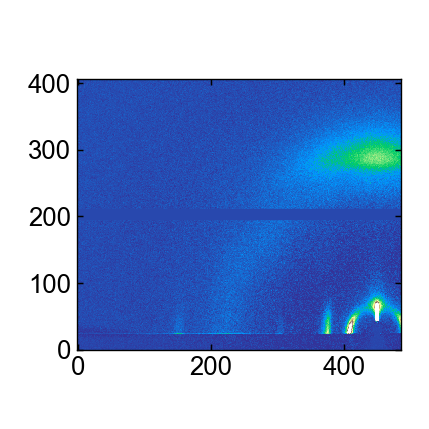

In [6]:
%matplotlib notebook

corrdata = data - darkscale
logdata = np.log(corrdata-np.min(corrdata)+1)

lmin, lmax = np.percentile(corrdata, (2, 99.9))
plt.figure()
plt.imshow(corrdata,cmap='terrain',vmin=lmin,vmax=lmax,origin='lower')

## Bright streak at y=25, bar from 195-211

<IPython.core.display.Javascript object>


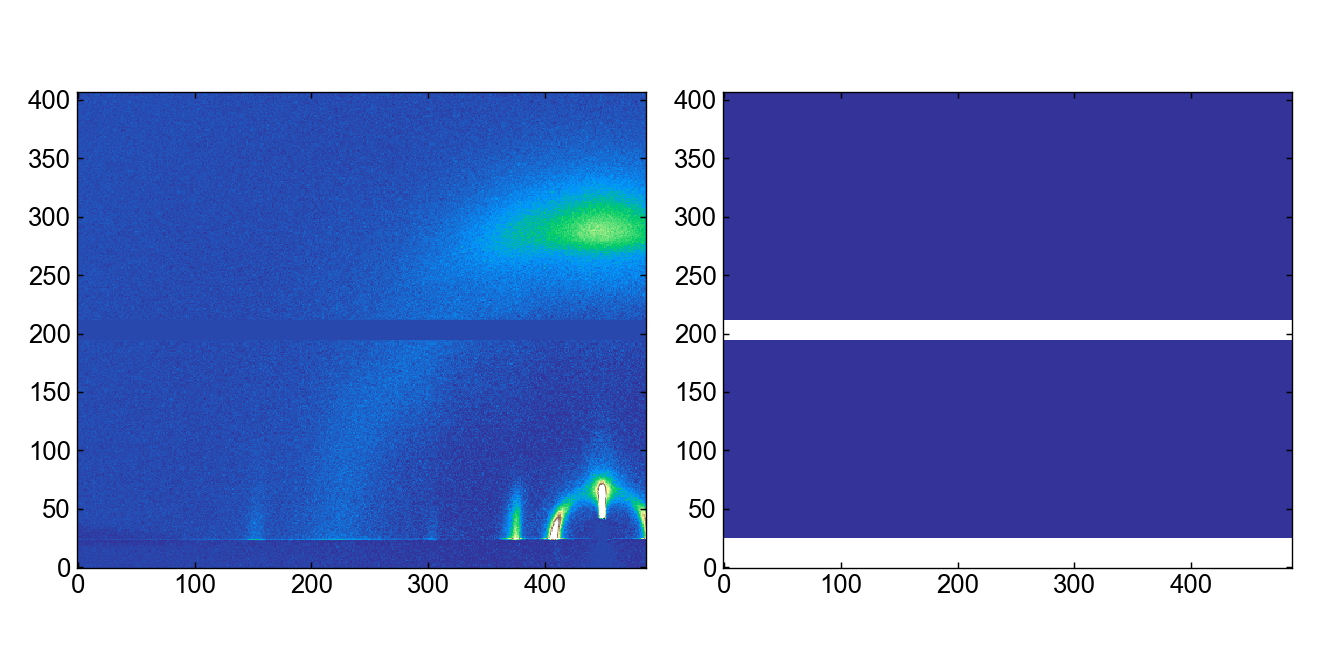

In [7]:
mask = np.zeros(data.shape)
mask[:26,:]=1
mask[195:212,:]=1

plt.figure(figsize=(10,5))
ax_raw = plt.subplot(121)
plt.imshow(corrdata,cmap='terrain',vmin=lmin,vmax=lmax,origin='lower')
plt.subplot(122, sharey=ax_raw, sharex=ax_raw)
plt.imshow(mask,cmap='terrain',origin='lower')

## Define pyFAI detector parameters

In [10]:
def setup_detector(data, theta, centery=26):

    ### Detector pixel size
    det_pix = [172e-6, 172e-6]

    detector = pyFAI.detectors.Detector(det_pix[0], det_pix[1])

    ### Wavelength
    wl = 0.97e-10

    ### Center-pixel and sample-to-detector distance
    centerx =  data.shape[1]-37.8
    centery = centery   # This is because I had to flip it upside-down
    sdd = 179.783e-3

    ### Beamcenter from sample view in meters from lower left of detector
    poni1 = centery * det_pix[1]; poni2 = centerx * det_pix[0]

    ### detector rotations from sample view
    rot1 = 0.0    /180 * np.pi # move detector to right, in-plane angle# in radians
    rot2 = 0.0    /180 * np.pi # move detector down, out-of-plane angle
    rot3 = 0.0    /180 * np.pi # clockwise rotation

    # Orientations and Angles
    sample_orientation = 1    # 1 is horizontal, 2 is vertical
    incident_angle = theta     # indicent angle in deg
    tilt_angle = 0            # tilt angle of sample in deg (misalignment in "chi")
    
    pg = pygix.Transform(dist = sdd, poni1 = poni1, poni2 = poni2,
                     rot1 = rot1, rot2 = rot2, rot3 = rot3,
                     wavelength = wl, sample_orientation = sample_orientation,
                     incident_angle = incident_angle, tilt_angle = tilt_angle,
                     detector=detector)
    
    return pg

## Setup detector and sample geometry, Get qxy-qz data

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\pygix-0.1.4a0-py3.6.egg\pygix\plotting.py:346: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif clim == 'auto':


<IPython.core.display.Javascript object>


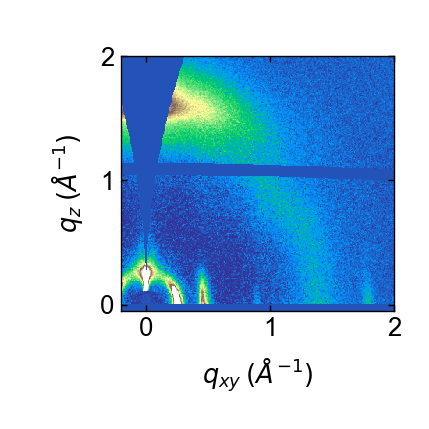

(<Figure size 312x312 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x6dcc0b8>)

In [11]:
pg = pygix.Transform(dist = sdd, poni1 = poni1, poni2 = poni2,
                     rot1 = rot1, rot2 = rot2, rot3 = rot3,
                     wavelength = wl, sample_orientation = sample_orientation,
                     incident_angle = incident_angle, tilt_angle = tilt_angle,
                     detector=detector)

imgt, qxy, qz = pg.transform_reciprocal(data, method='lut', correctSolidAngle=True, unit='A', dark=darkscale, mask=mask)
corrimg = imgt-np.min(imgt)+1
logimg = np.log(corrimg)

clim = np.percentile(logimg, (2.5, 99.8))
ppl.implot(logimg, qxy, qz, mode='rsma', cmap="terrain", clim=clim, xlim=(-0.2,2), ylim=(-0.05,2))

## Peep the nice dual image

<IPython.core.display.Javascript object>


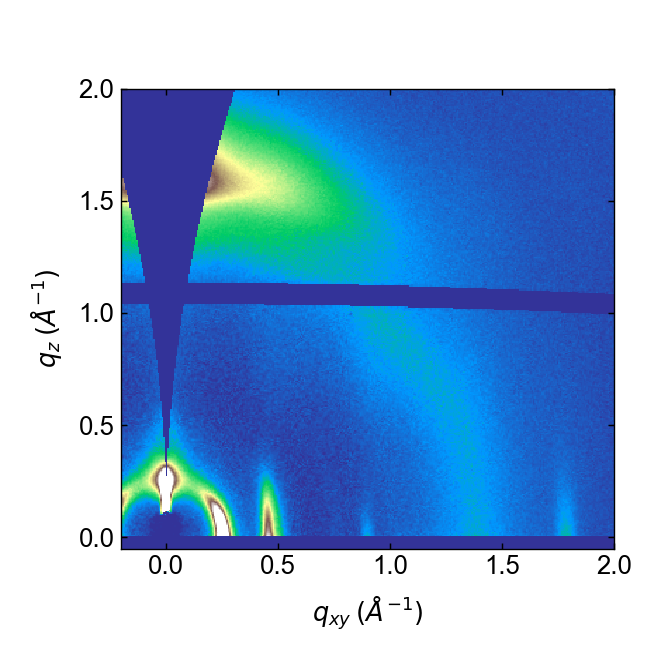

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\pygix-0.1.4a0-py3.6.egg\pygix\plotting.py:346: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif clim == 'auto':


In [12]:
dual_file = os.path.join(os.path.split(figfolder)[0],'{}_dual.png'.format(run_name))

dual_tiff = df['fullpath'].loc[df['movie_num']==dual_movie].iloc[0]
dual_exp = df['exp_time'].loc[df['movie_num']==dual_movie].iloc[0]
dual_data = fabio.open(dual_tiff).data
dual_data = np.flipud(dual_data)
darkscale_dual = (dual_exp/dark_exp)*dark

pg2 = pygix.Transform(dist = sdd, poni1 = poni1, poni2 = poni2,
                     rot1 = rot1, rot2 = rot2, rot3 = rot3,
                     wavelength = wl, sample_orientation = sample_orientation,
                     incident_angle = incident_angle, tilt_angle = tilt_angle,
                     detector=detector)

dualt, qxy, qz = pg2.transform_reciprocal(dual_data, method='lut', correctSolidAngle=True, unit='A', dark=darkscale_dual, mask=mask)
corrdual = dualt-np.min(dualt)+1
logdual = np.log(corrdual)

clim = np.percentile(logdual, (2.5, 99.8))
plt.figure(figsize=(5,5))
ppl.implot(logdual, qxy, qz, mode='rsma', cmap="terrain",
           clim=clim, xlim=(-0.2,2), ylim=(-0.05,2),
           newfig=False)
plt.savefig(dual_file)

## Look at the AOI series

<IPython.core.display.Javascript object>


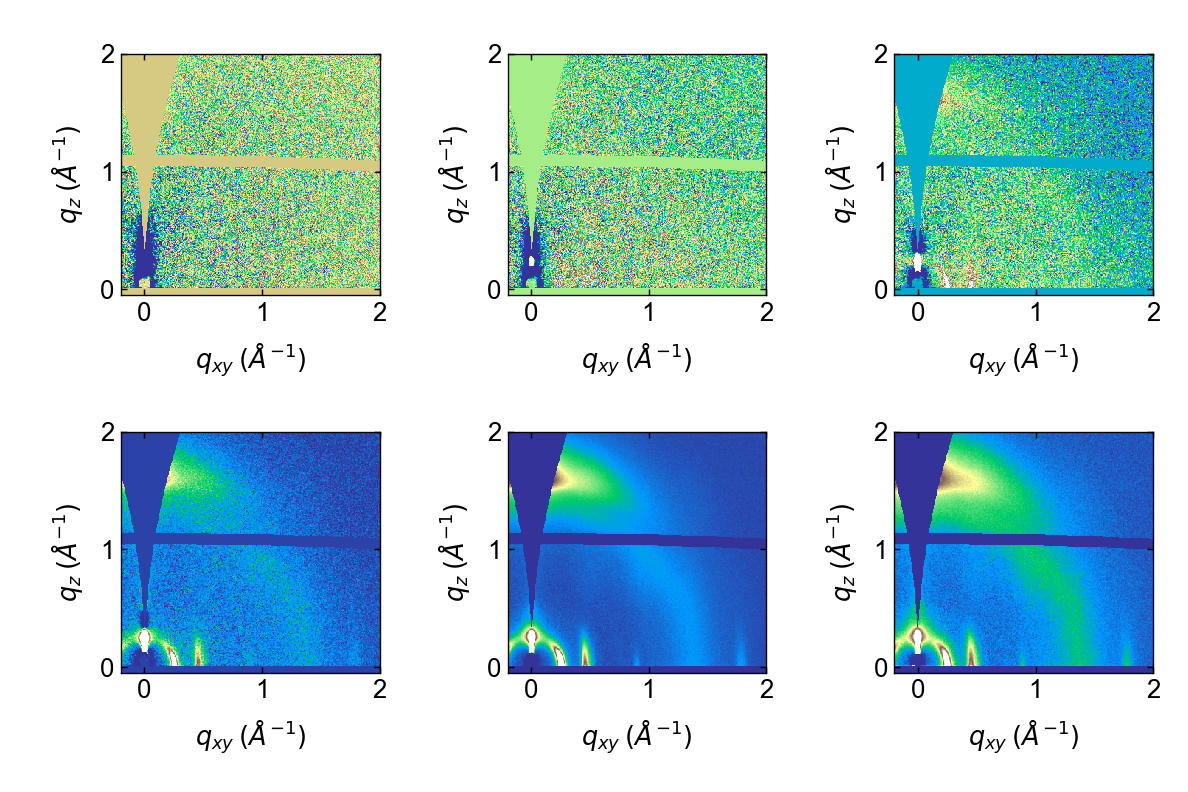

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\pygix-0.1.4a0-py3.6.egg\pygix\plotting.py:346: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif clim == 'auto':


In [13]:
plt.figure(figsize=(9,6))
aoi_file = os.path.join(os.path.split(figfolder)[0],'{}_aoi_series.png'.format(run_name))

for i in range(6):
    
    temp_movie_num = i + aoi_start
    aoi_tiff = df['fullpath'].loc[df['movie_num']==temp_movie_num].iloc[0]
    aoi_exp = df['exp_time'].loc[df['movie_num']==temp_movie_num].iloc[0]
    aoi_data = fabio.open(aoi_tiff).data
    aoi_data = np.flipud(aoi_data)
    darkscale_aoi = (aoi_exp/dark_exp)*dark

    pg3 = pygix.Transform(dist = sdd, poni1 = poni1, poni2 = poni2,
                         rot1 = rot1, rot2 = rot2, rot3 = rot3,
                         wavelength = wl, sample_orientation = sample_orientation,
                         incident_angle = incident_angle, tilt_angle = tilt_angle,
                         detector=detector)

    aoit, qxy, qz = pg3.transform_reciprocal(aoi_data, method='lut', correctSolidAngle=True, unit='A', dark=darkscale_aoi, mask=mask)
    corraoi = aoit-np.min(aoit)+1
    logaoi = np.log(corraoi)
    
    clim = np.percentile(logaoi, (2.5, 99.8))
    plt.subplot(2,3,i+1)
    ppl.implot(logaoi, qxy, qz, mode='rsma', cmap="terrain",
               clim=clim, xlim=(-0.2,2), ylim=(-0.05,2),
               newfig=False)
    
plt.savefig(aoi_file)

## Get out-of-plane sector

Then do this for all runs and plot vs. time

In [14]:
r_range = (0.1, 2)

<IPython.core.display.Javascript object>


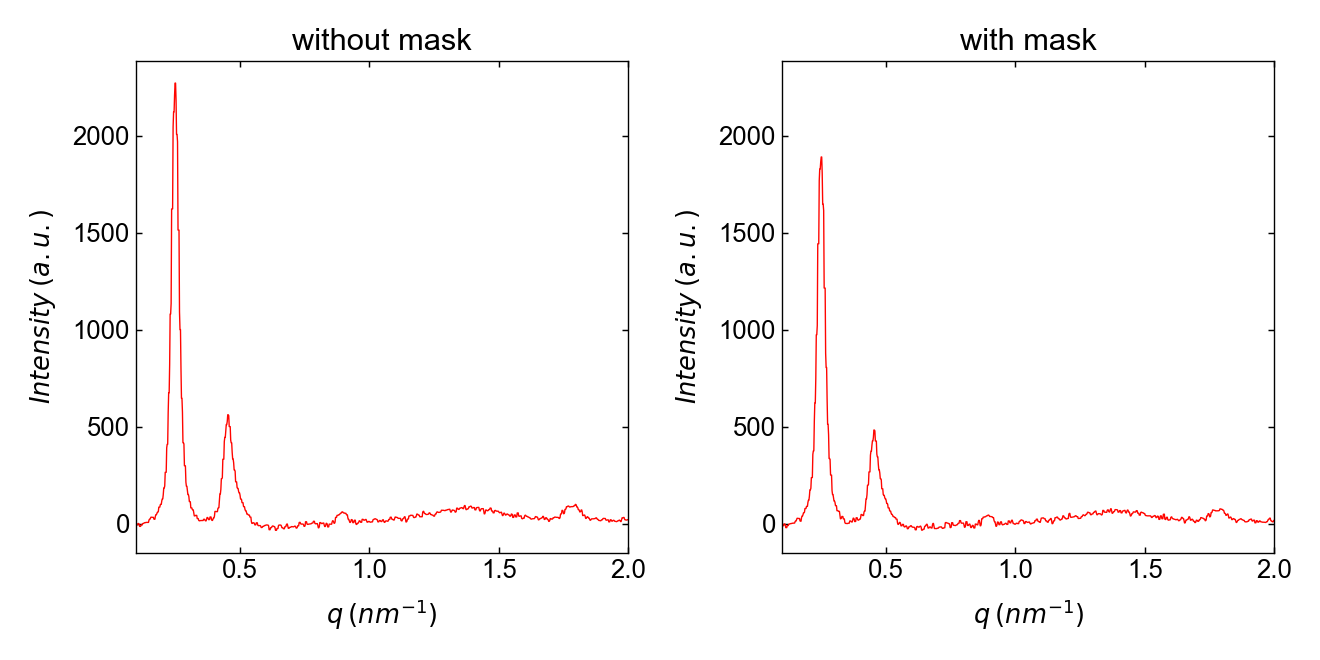

Text(0.5,1,'with mask')

In [15]:
%matplotlib notebook
int_sect, q_sect = pg.profile_ip_box(data, npt=1000, op_pos=0.025,
                                     op_width=0.05, ip_range=r_range,
                                     correctSolidAngle=True,
                                     unit='q_A^-1', #mask=mask,
                                     method='lut', dark=darkscale)
int_sect_mask, q_sect_mask = pg.profile_ip_box(data, npt=1000, op_pos=0.025,
                                     op_width=0.05, ip_range=r_range,
                                     correctSolidAngle=True,
                                     unit='q_A^-1', mask=mask,
                                     method='lut', dark=darkscale)

plt.figure(figsize=(10,5))
ax_mask=plt.subplot(121)
ppl.plot(q_sect,int_sect, newfig=False)
plt.title('without mask')
plt.subplot(122,sharex=ax_mask,sharey=ax_mask)
ppl.plot(q_sect_mask, int_sect_mask, newfig=False)
plt.title('with mask')

In [16]:
df['sect_ip'] = df['fullpath'].apply(lambda f:
                                     pg.profile_ip_box(np.flipud(fabio.open(f).data), npt=1000, op_pos=0.025,
                                         op_width=0.05, ip_range=r_range,
                                         correctSolidAngle=True,
                                         unit='q_A^-1', mask=mask,
                                         method='lut', dark=darkscale)[0]
                                    )

df_mov = df.loc[df['movie_num']==main_movie].copy()
df_mov[['shot_num','sect_ip']].head()

shot_num                                            sect_ip
3         0  [-9.732897, 11.2544985, 11.2544985, -8.932913,...
4         1  [-3.753192, -20.133478, -20.133478, -16.983618...
5         2  [-7.7242594, -13.255667, -13.255667, -19.46281...
6         3  [-20.094961, -15.381607, -15.381607, -6.585211...
7         4  [-15.10682, -6.8777194, -6.8777194, -1.795185,...

<IPython.core.display.Javascript object>


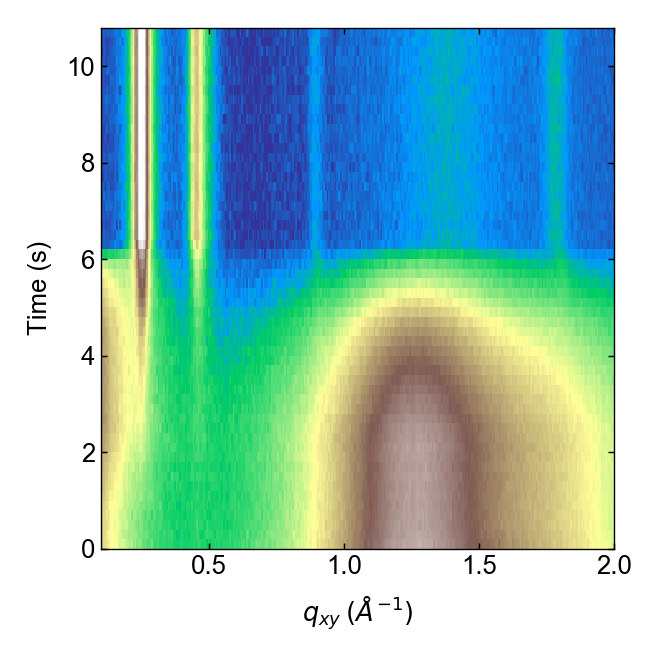

Text(0,0.5,'Time (s)')

In [17]:
%matplotlib notebook

sect_array = np.vstack(df_mov['sect_ip'])
log_sect_array = np.log(sect_array-np.min(sect_array)+1)

xray_start = 71; xray_stop = 125;
log_sect_crop = log_sect_array[xray_start:xray_stop,:]
vminx, vmaxx = np.percentile(log_sect_crop, (1, 99.7))
extent_xray = [q_sect[0], q_sect[-1], 0, (xray_stop-xray_start)/5]

plt.figure(figsize=(5,5))
plt.imshow(log_sect_crop,
            origin='lower', aspect='auto',
            vmin=vminx, vmax=vmaxx,
            interpolation='nearest',
            cmap='terrain',
            extent=extent_xray)

plt.xlabel(r'$q_{xy} \: (\AA^{-1})$')
plt.ylabel('Time (s)')

### At what time does the blade pass? And when is the spectrum stable?

In [18]:
print('set xray_start to: {}'.format(14.2 / xray_dt))
print('set xray_stop to: {}'.format(25 / xray_dt))

df_mov['time'] = df_mov['shot_num'].apply(lambda x: (x - xray_start) * df_mov['exp_time'].iloc[0])
df_mov['log_sect'] = [row for row in log_sect_array]

df_mov = df_mov.loc[(df_mov['shot_num']>=xray_start) & (df_mov['shot_num']<xray_stop)].copy()

set xray_start to: 70.99999999999999
set xray_stop to: 125.0


## Set up peak fitting

In [19]:
def plot_peak_fits(x,y,df_peaks,out_dict, log_scale=True):

    color_list = ['#3cb44b','#0082c8','#f58231','#911eb4','#800000','#000080','#808000']
    f1 = plt.figure()
    
    if log_scale:
        plt.semilogy(x, y, 'r-')
    else:
        plt.plot(x, y, 'r-')
        
    for i in df_peaks['set'].unique():
        
        out = out_dict[i]
        df_set = df_peaks.loc[df_peaks.set==i]
        
        # Build bounded x and y vectors
        lb = df_set.iloc[0].lb
        ub = df_set.iloc[0].ub
        lb_ind = int(np.where(x>=lb)[0][0])
        ub_ind = int(np.where(x>=ub)[0][0])
        xb = x[lb_ind:ub_ind]
        yb = y[lb_ind:ub_ind]

        # Add peaks to plot
        comps = out.eval_components(x=xb)
        
        if log_scale:
            plt.semilogy(xb, out.eval(x=xb), '-', color = color_list[i])
            for c in comps:
                try:
                    plt.semilogy(xb, comps[c], '--', color = color_list[i])
                except:
                    const_eval = np.ones(xb.shape)*comps[c]
                    plt.semilogy(xb, const_eval, '--', color = color_list[i])
        else:
            plt.plot(xb, out.eval(x=xb), '-', color = color_list[i])
            for c in comps:
                try:
                    plt.plot(xb, comps[c], '--', color = color_list[i])
                except:
                    const_eval = np.ones(xb.shape)*comps[c]
                    plt.plot(xb, const_eval, '--', color = color_list[i])

    # Show the plot
    if log_scale==True:
        f1.axes[0].set_ylim( bottom=max(1,np.min(y)/10), top=np.max(y)*1.3 )
    else:
        f1.axes[0].set_ylim( bottom=np.min(y)-(np.max(y)-np.min(y))/10, top=np.max(y)*1.1 )
        
    plt.show()

In [20]:
# Peak Fitting
from lmfit.models import GaussianModel, LorentzianModel, ExponentialModel, ConstantModel, LinearModel, VoigtModel

def fit_peaks(x, y, df_peak_init, fix_sigma=False, fix_center=False, fix_gamma=False):
    
    df_new = df_peak_init.copy()
    out_dict = {}
    
    # Run peak fits for each set of peaks
    for i in df_new['set'].unique():
        
        df_peaks = df_new.loc[df_new.set==i]

        # Build bounded x and y vectors
        lb = df_peaks.iloc[0].lb
        ub = df_peaks.iloc[0].ub
        lb_ind = int(np.where(x>=lb)[0][0])
        ub_ind = int(np.where(x>=ub)[0][0])
        xb = x[lb_ind:ub_ind]
        yb = y[lb_ind:ub_ind]

        # Initialize Baseline model
        comp_mod = []

        if i not in []:
            lin_mod = LinearModel(prefix='lin_')
            pars = lin_mod.make_params(m=0,b=yb.min())
            comp_mod.append(lin_mod)
        else:
            lin_mod = ExponentialModel(prefix='lin_')
            pars = lin_mod.guess(y,x=x)
            comp_mod.append(lin_mod)

        # Add peaks
        for index, peak in df_peaks.iterrows():
            prefix = peak['name']+'_'
            peak_temp  = VoigtModel(prefix=prefix)

            pars.update(peak_temp.make_params())
            pars[prefix+'center'].set(peak['cent'], min=peak['min'], max=peak['max'])
            if fix_center:
                pars[prefix+'center'].set(vary=False)
            pars[prefix+'sigma'].set(peak['sig'])
            if fix_sigma:
                pars[prefix+'sigma'].set(vary=False)
            if fix_gamma:
                pars[prefix+'gamma'].set(peak['gam'])
                pars[prefix+'gamma'].set(vary=False)
            
            pars[prefix+'amplitude'].set(peak['amp'], min=0)
            
            # Fix the (200) amplitude to the (100)
            if prefix=='p200_':
                p100_amplitude_fit = out_dict[1].best_values['p100_amplitude']
                pars[prefix+'amplitude'].set(expr='{} / 40'.format(p100_amplitude_fit))

            comp_mod.append(peak_temp)

        # Build composite model
        comp_mod = np.sum(comp_mod)
        out = comp_mod.fit(yb, pars, x=xb)
        params_dict=out.params.valuesdict()

        # Store peak features in original dataframe
        for peak, prop in [s.split('_') for s in list(params_dict.keys())]:
            df_new.loc[df_new.name==peak,prop] = params_dict[peak+'_'+prop]
        out_dict[i] = out
        
    return df_new, out_dict

## Do a test fit

In [21]:
p100 = {'name': 'p100', 'set':1, 'cent': .23, 'min': .20, 'max': .30, 'sig': .01, 'amp': 50, 'lb': .16, 'ub': .37}

p001 = {'name': 'p001', 'set':2, 'cent': .45, 'min': .40, 'max': .47, 'sig': .01, 'amp': 10, 'lb': .36, 'ub': .6}
p200 = {'name': 'p200', 'set':2, 'cent': .49, 'min': .48, 'max': .55, 'sig': .01, 'amp': 10, 'lb': .36, 'ub': .6}

p002a ={'name': 'p002a', 'set':3, 'cent': 1.77, 'min': 1.7, 'max': 1.84, 'sig': 0.01, 'amp': 1, 'lb': 1.67, 'ub': 1.88}

df_peak_init = pd.DataFrame.from_dict([p100,p001,p200,p002a])
df_peak_init

amp  cent    lb   max   min   name  set   sig    ub
0   50  0.23  0.16  0.30  0.20   p100    1  0.01  0.37
1   10  0.45  0.36  0.47  0.40   p001    2  0.01  0.60
2   10  0.49  0.36  0.55  0.48   p200    2  0.01  0.60
3    1  1.77  1.67  1.84  1.70  p002a    3  0.01  1.88

<IPython.core.display.Javascript object>


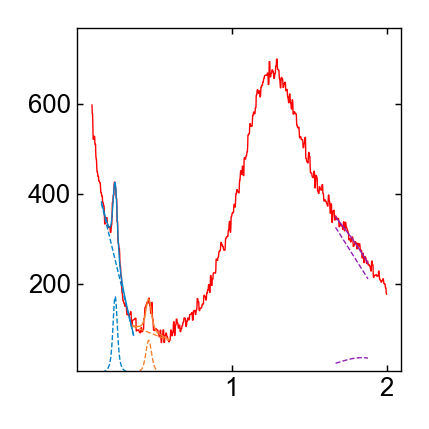

4.0


In [22]:
plotrow=20
x1 = q_sect; y1 = df_mov['sect_ip'].iloc[plotrow]
df_new, out_dict = fit_peaks(x1,y1,df_peak_init,fix_sigma=False,fix_center=False)
plot_peak_fits(x1,y1,df_new,out_dict, log_scale=False)
df_new #[['name','center','amplitude','sigma']]
print(df_mov.time.iloc[plotrow])

## Run an unconstrained fit on all the data

In [23]:
df_mov[['peaks','fits']] = df_mov.apply(lambda r: pd.Series(fit_peaks(q_sect, r['sect_ip'], df_peak_init)[0:2]),
                                        axis=1)

In [24]:
df_mov['peaks'].iloc[-1]

amp  cent    lb   max   min   name  set   sig    ub  intercept  slope  \
0   50  0.23  0.16  0.30  0.20   p100    1  0.01  0.37        NaN    NaN   
1   10  0.45  0.36  0.47  0.40   p001    2  0.01  0.60        NaN    NaN   
2   10  0.49  0.36  0.55  0.48   p200    2  0.01  0.60        NaN    NaN   
3    1  1.77  1.67  1.84  1.70  p002a    3  0.01  1.88        NaN    NaN   

      sigma    center  amplitude     gamma      fwhm       height  
0  0.010319  0.250678  85.539667  0.010319  0.037161  3307.093401  
1  0.012622  0.455872  28.186362  0.012622  0.045456   890.880516  
2  0.006885  0.502638   2.138492  0.006885  0.024796   123.909318  
3  0.019430  1.784800   5.984281  0.019430  0.069973   122.872166

## Get average peak widths toward end of run

In [25]:
p100_sigma = np.mean([p['sigma'].loc[0] for p in df_mov['peaks'].iloc[-10:]])
p100_sigma

0.010313168713327502

In [26]:
for i in df_peak_init.index.values:
    df_peak_init.loc[i,'sig'] = np.mean([p['sigma'].loc[i] for p in df_mov['peaks'].iloc[-10:]])
    df_peak_init.loc[i,'cent'] = np.mean([p['center'].loc[i] for p in df_mov['peaks'].iloc[-10:]])
    df_peak_init.loc[i,'gam'] = np.mean([p['gamma'].loc[i] for p in df_mov['peaks'].iloc[-10:]])
    
df_peak_init

amp      cent    lb   max   min   name  set       sig    ub       gam
0   50  0.250697  0.16  0.30  0.20   p100    1  0.010313  0.37  0.010313
1   10  0.455991  0.36  0.47  0.40   p001    2  0.012783  0.60  0.012783
2   10  0.506514  0.36  0.55  0.48   p200    2  0.008273  0.60  0.008273
3    1  1.784737  1.67  1.84  1.70  p002a    3  0.021356  1.88  0.021356

## Re-fit with fixed peak widths, centers, and gamma

In [27]:
df_mov[['peaks','fits']] = df_mov.apply(lambda r: pd.Series(fit_peaks(q_sect, r['sect_ip'], df_peak_init,
                                                                             fix_sigma=True, fix_center=True, fix_gamma=True)[0:2]),
                                        axis=1)

In [28]:
df_mov['peaks'].iloc[-1]

amp      cent    lb   max   min   name  set       sig    ub       gam  \
0   50  0.250697  0.16  0.30  0.20   p100    1  0.010313  0.37  0.010313   
1   10  0.455991  0.36  0.47  0.40   p001    2  0.012783  0.60  0.012783   
2   10  0.506514  0.36  0.55  0.48   p200    2  0.008273  0.60  0.008273   
3    1  1.784737  1.67  1.84  1.70  p002a    3  0.021356  1.88  0.021356   

   intercept  slope     sigma    center  amplitude     gamma      fwhm  \
0        NaN    NaN  0.010313  0.250697  85.500761  0.010313  0.037141   
1        NaN    NaN  0.012783  0.455991  28.540922  0.012783  0.046037   
2        NaN    NaN  0.008273  0.506514   2.137519  0.008273  0.029793   
3        NaN    NaN  0.021356  1.784737   6.618499  0.021356  0.076908   

        height  
0  3307.409296  
1   890.704373  
2   103.078266  
3   123.640157

## Herman's Orientation and in-plane anisotropy over time

In [29]:
def get_data(row):
    
    data = np.flipud(fabio.open(row['fullpath']).data)
    return data-np.min(data.ravel())+1


def get_pole_figure(df, sample, chi_range=(-90,0), q_range=(0,2), npt=(180,180)):
    
    data = get_data(df.loc[sample])
    theta = df.loc[sample].theta
    pg = setup_detector(data, theta, centery=25.5)
    print(data.shape)
    
    intensity, q_abs, chi = pg.transform_polar(data, unit='A', mask=mask,
                                               npt=npt,
                                               chi_range=chi_range, q_range=q_range,
                                               correctSolidAngle=True,
                                               method='splitpix')
    
    return intensity, q_abs, chi


def Hermans(ii, chi):
    """
    This function will sin-weight the intensity... do no pass sin-weighted intensity...
    """
    sin_chi = np.sin(np.deg2rad(chi))
    cos2chi = np.cos(np.deg2rad(chi)) ** 2
    expect = np.sum(ii * cos2chi * sin_chi) / np.sum(ii * sin_chi)
    return (3*expect-1)/2


def interp_nans(data):
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    return data


def get_polar_cut(intensity, q_abs, chi, qb, qbg):
    
    """
    Given a polar transform of a 2-D image, get
    a polar line cut within the q values qb, with
    background subtracted from the q locations in qbg
    (typically two locations just outside of qb).
    3 lines will be sampled at each qbg (+/- 1 pixel)
    
    Return: cut (bg-corrected intensity)
            hof (Herman's Orientation Factor for the cut)
    """

    q_pix = np.array([np.where(q_abs>qb[0])[0][0], np.where(q_abs>qb[1])[0][0]])
    q_bg_pix = np.array([np.where(q_abs>qbg[0])[0][0], np.where(q_abs>qbg[1])[0][0]])
    q_bg_pix = np.hstack([q_bg_pix, q_bg_pix+1, q_bg_pix-1])

    cut = intensity[:,q_pix[0]:q_pix[1]].sum(axis=1)/np.diff(q_pix) - np.mean(intensity[:,q_bg_pix], axis=1)
    hof = Hermans(cut, chi)
    cut_sin_weighted = cut * np.abs(np.sin(np.deg2rad(chi)))
    
    return cut_sin_weighted, hof


def pcolor(img, newfig=True, figsize=(5,4), extent=None,
           clip_val=None, prcs=(2,99.5),
           cmap='terrain', aspect='auto', origin=None):
    
    if newfig:
        plt.figure(figsize=figsize)
    
    if clip_val:
        cmin, cmax = np.percentile(img[img>clip_val], prcs)
    else:
        cmin, cmax = np.percentile(img, prcs)
        
    plt.imshow(img, cmap=cmap, vmin=cmin, vmax=cmax,
               extent=extent, aspect=aspect, origin=origin)

In [30]:
df_mov

fullpath  \
74   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
75   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
76   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
77   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
78   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
79   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
80   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
81   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
82   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
83   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
84   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
85   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
86   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
87   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
88   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
89   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
90   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
91   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
92   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
93   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
94   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
95   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
96   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
97   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
98   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
99   F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
100  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
101  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
102  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
103  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
104  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
105  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
106  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
107  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
108  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
109  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
110  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
111  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
112  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
113  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
114  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
115  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
116  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
117  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
118  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
119  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
120  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
121  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
122  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
123  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
124  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
125  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
126  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   
127  F:\N2200 Project\data\chess_apr18\n22tol20_hi_...   

                           filename   solvent speed grooves repeat  movie_num  \
74   n22tol20_hi_nogr_1_3_0071.tiff  n22tol20    hi    nogr      1          3   
75   n22tol20_hi_nogr_1_3_0072.tiff  n22tol20    hi    nogr      1          3   
76   n22tol20_hi_nogr_1_3_0073.tiff  n22tol20    hi    nogr      1          3   
77   n22tol20_hi_nogr_1_3_0074.tiff  n22tol20    hi    nogr      1          3   
78   n22tol20_hi_nogr_1_3_0075.tiff  n22tol20    hi    nogr      1          3   
79   n22tol20_hi_nogr_1_3_0076.tiff  n22tol20    hi    nogr      1          3   
80   n22tol20_hi_nogr_1_3_0077.tiff  n22tol20    hi    nogr      1          3   
81   n22tol20_hi_nogr_1_3_0078.tiff  n22tol20    hi    nogr      1          3   
82   n22tol20_hi_nogr_1_3_0079.tiff  n22tol20    hi    nogr      1          3   
83   n22tol20_hi_nogr_1_3_0080.tiff  n22tol20

(407, 487)


<IPython.core.display.Javascript object>


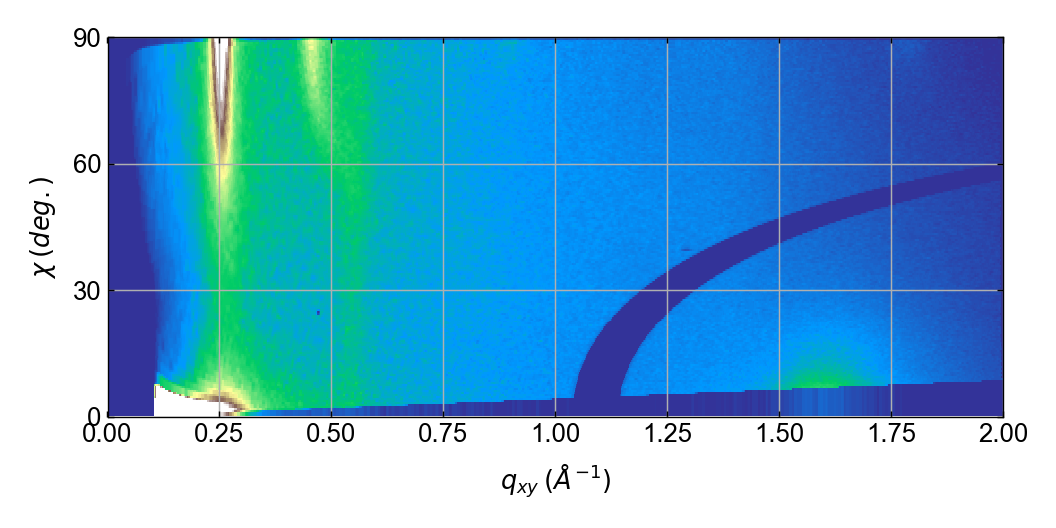

In [31]:
intensity, q_abs, chi = get_pole_figure(df_mov, 127, chi_range=(0,90),
                                        q_range=(0,2), npt=(1000,190))
pcolor(intensity, figsize=(8,4),
       extent=[q_abs.min(), q_abs.max(), chi.min(), chi.max()],
       origin='lower', prcs=(10,99.5))
plt.xlabel(r'$q_{xy} \: (\AA^{-1})$')
plt.ylabel(r'$\chi \: (deg.)$')
plt.gca().grid(True)
plt.gca().set_yticks([0, 30, 60, 90])
# plt.savefig("tol_hi_ng_0_pole_fig.png")

<IPython.core.display.Javascript object>


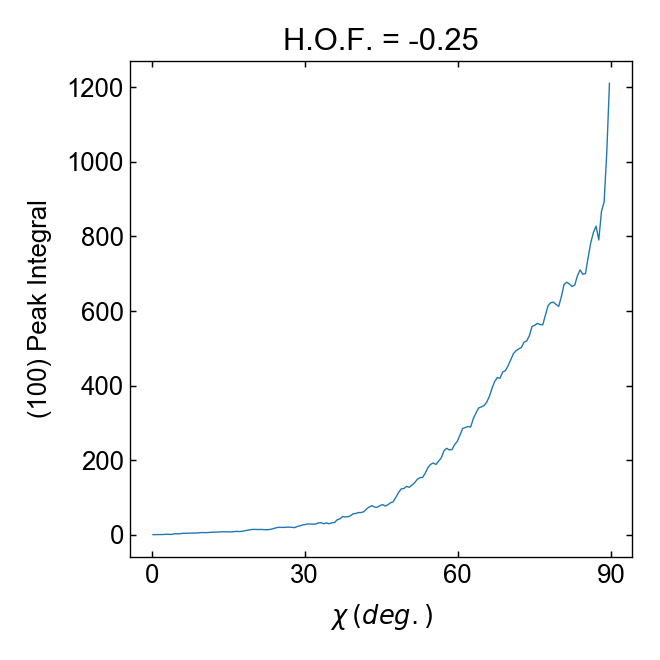

([<matplotlib.axis.XTick at 0x18fbf860>,
 <a list of 4 Text xticklabel objects>)

In [49]:
qb = (0.21, 0.3); qbg = (0.2, 0.35);
cut, hof = get_polar_cut(intensity, q_abs, chi, qb, qbg)
plt.figure(figsize=(5,5))
plt.plot(chi,cut * np.abs(np.sin(chi * np.pi / 180)))
plt.xlabel(r'$\chi \: (deg.)$'); plt.ylabel("(100) Peak Integral")
plt.title("H.O.F. = {}".format(np.round(hof, decimals=2)))
plt.xticks([0,30,60,90])
# plt.savefig('tol_hi_ng_0_(100)_pole.png')

In [34]:
qb = (0.21, 0.3); qbg = (0.2, 0.35);
poles_100 = pd.Series()

for ii in df_mov.index.values:
    print(ii)
    intensity, q_abs, chi = get_pole_figure(df_mov, ii, chi_range=(0,90),
                                            q_range=(0,2), npt=(1000,86*2))
    cut, hof = get_polar_cut(intensity, q_abs, chi, qb, qbg)
    poles_100.loc[ii] = cut
    df_mov.loc[ii,'Hermans'] = hof

df_mov['pole_100'] = poles_100

74
(407, 487)
75
(407, 487)
76
(407, 487)
77
(407, 487)
78
(407, 487)
79
(407, 487)
80
(407, 487)
81
(407, 487)
82
(407, 487)
83
(407, 487)
84
(407, 487)
85
(407, 487)
86
(407, 487)
87
(407, 487)
88
(407, 487)
89
(407, 487)
90
(407, 487)
91
(407, 487)
92
(407, 487)
93
(407, 487)
94
(407, 487)
95
(407, 487)
96
(407, 487)
97
(407, 487)
98
(407, 487)
99
(407, 487)
100
(407, 487)
101
(407, 487)
102
(407, 487)
103
(407, 487)
104
(407, 487)
105
(407, 487)
106
(407, 487)
107
(407, 487)
108
(407, 487)
109
(407, 487)
110
(407, 487)
111
(407, 487)
112
(407, 487)
113
(407, 487)
114
(407, 487)
115
(407, 487)
116
(407, 487)
117
(407, 487)
118
(407, 487)
119
(407, 487)
120
(407, 487)
121
(407, 487)
122
(407, 487)
123
(407, 487)
124
(407, 487)
125
(407, 487)
126
(407, 487)
127
(407, 487)


<IPython.core.display.Javascript object>


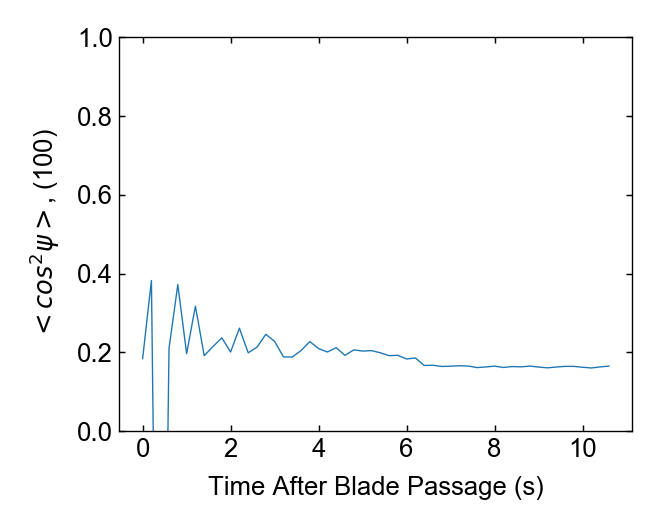

In [52]:
plt.figure(figsize=(5,4))
plt.plot(df_mov['time'], (df_mov['Hermans']*2+1)/3)
plt.xlabel('Time After Blade Passage (s)')
plt.ylabel("$<cos^2 \psi>$, (100)")
plt.ylim([0,1])
plt.savefig(os.path.join(os.path.split(figfolder)[0],'{}_HOFvTime.png'.format(run_name)))

<IPython.core.display.Javascript object>


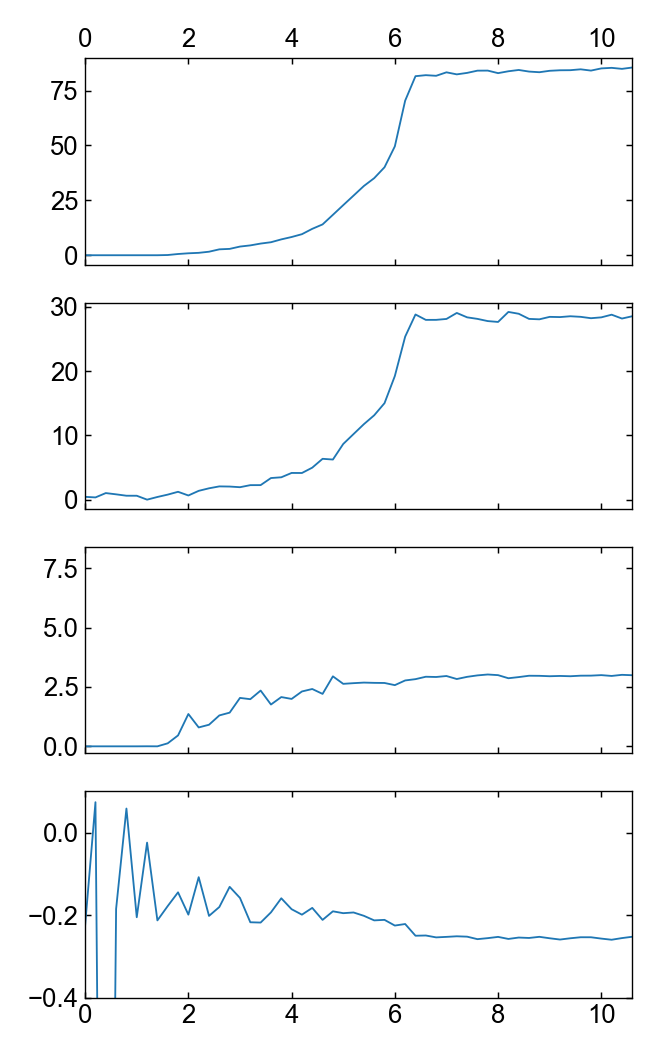

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [36]:
%matplotlib notebook

t_start = 0
t_stop = df_mov['time'].max()
linew = 1
what = 'amplitude'
which = 'sigma'

gy=4
gx=1

plt.figure(figsize=(5,8))
plt.tight_layout()

plt.subplot(gy,gx,1)
pn1 = 0
plt.plot(df_mov['time'],[p[what].loc[pn1] for p in df_mov.peaks],
         linewidth=linew)
# plt.ylabel('{} {} (a.u.)'.format(df_mov.peaks.iloc[0]['name'].loc[pn1], what))
plt.xlim((t_start,t_stop))
plt.tick_params(labelbottom=False)
plt.tick_params(labeltop=True)
# plt.ylim((-0.3,10))


plt.subplot(gy,gx,2)
pn2 = 1
plt.plot(df_mov['time'],[p[what].loc[pn2] for p in df_mov.peaks],
         linewidth=linew)
# plt.xlabel('Time after blade passage (s)')
# plt.ylabel('{} {} (a.u.)'.format(df_mov.peaks.iloc[0]['name'].loc[pn2], what))
plt.xlim((t_start,t_stop))
plt.tick_params(labelbottom=False)


plt.subplot(gy,gx,3)
plt.plot(df_mov['time'],[p[what].loc[0]/p[what].loc[1] for p in df_mov.peaks],
         linewidth=linew)
# plt.xlabel('Time after blade passage (s)')
# plt.ylabel('(100)/(001) Ratio')
plt.xlim((t_start,t_stop))
plt.ylim((-0.3,8.4))
plt.tick_params(labelbottom=False)


plt.subplot(gy,gx,4)
plt.plot(df_mov['time'],df_mov['Hermans'],
         linewidth=linew)
# plt.xlabel('Time after blade passage (s)')
# plt.ylabel("H.O.F. (100)")
plt.xlim((t_start,t_stop))
plt.ylim((-0.4,0.1))

pr_file = os.path.join(os.path.split(figfolder)[0],'{}_XvTime.png'.format(run_name))
plt.savefig(pr_file, dpi=300, bbox_inches='tight')

## Great, now let's work on the UV

We're going to do a median filter on the straight channel to smooth it out.

In [37]:
straight0 = np.loadtxt(uv_straight[0], skiprows=17, comments='>')
waves = straight0[:,0]
straight_raw = np.array([np.transpose(np.loadtxt(tt,skiprows=17,comments='>')[:,1]) for tt in uv_straight])
straight_raw.shape

(1198, 2048)

In [38]:
from scipy.signal import medfilt

straight_array = np.array([medfilt(row, kernel_size=5) for row in straight_raw])

In [39]:
kicked_raw = np.array([np.transpose(np.loadtxt(tt,skiprows=17,comments='>')[:,1]) for tt in uv_kicked])
kicked_array = np.array([medfilt(row, kernel_size=5) for row in kicked_raw])
kicked_array.shape

(1198, 2048)

### Plot example spectra

<IPython.core.display.Javascript object>


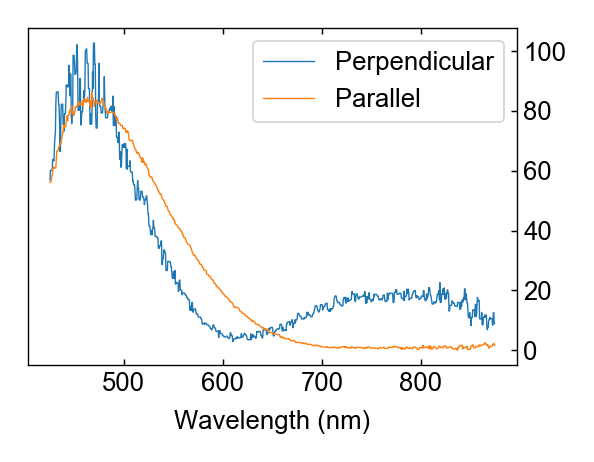

F:\N2200 Project\figures\chess_apr18\n22tol20_hi_nogr_1_uvr.png


In [40]:
w_start = 425; w_stop = 875
w_start_ind = np.where(waves>w_start)[0][0]
w_stop_ind = np.where(waves>w_stop)[0][0]
waves_crop = waves[w_start_ind:w_stop_ind]

%matplotlib notebook
f = plt.figure(figsize=(4.5,3.5))
f.patch.set_facecolor('w')
f.patch.set_alpha(0)

plt.plot(waves_crop,straight_array[-1,w_start_ind:w_stop_ind],
         waves_crop,kicked_array[-1,w_start_ind:w_stop_ind])
plt.xlabel('Wavelength (nm)')
# plt.ylabel('Reflectance (%)')
ax_uvr = plt.gca()
ax_uvr.yaxis.set_ticks_position("right")
ax_uvr.yaxis.set_label_position("right")
ax_uvr.patch.set_facecolor('white')
ax_uvr.patch.set_alpha(1)

plt.legend(['Perpendicular','Parallel'])

uv_raw_file = os.path.join(os.path.split(figfolder)[0],'{}_uvr.png'.format(run_name))
plt.savefig(uv_raw_file)
print(uv_raw_file)

## Find the spectrum where you'll start t=0

<IPython.core.display.Javascript object>


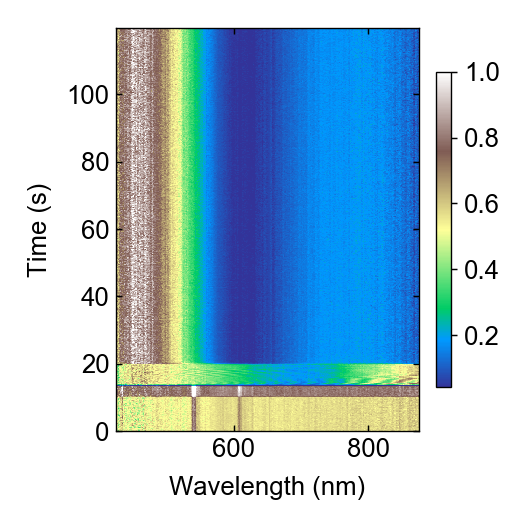

In [41]:
%matplotlib notebook

spec_start = 0; spec_stop = straight_array.shape[0];
straight_crop = straight_array[spec_start:spec_stop,w_start_ind:w_stop_ind].clip(min=0.1,max=100)/100

vmins, vmaxs = np.percentile(straight_crop, (2.5, 99.8))
extent_wli = [waves[w_start_ind], waves[w_stop_ind], 0, (spec_stop-spec_start)/10]

plt.figure(figsize=(4,4))
plt.imshow(straight_crop,
                origin='lower', aspect='auto',
                vmin=vmins, vmax=vmaxs,
                interpolation='nearest',
                cmap='terrain',
                extent=extent_wli)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Time (s)')
plt.colorbar(fraction=0.047, pad=0.05).ax.tick_params(axis='y', direction='out')

### At what time does the blade pass? Then calculate stop frame from xray stop frame

In [42]:
print('set uv_start to: {}'.format(13.7 / uv_dt))
print('set uv_stop to: {}'.format( (13.7 + (xray_stop-xray_start)*xray_dt) / uv_dt ))

set uv_start to: 136.99999999999997
set uv_stop to: 245.0


## Plot the straight and kicked spectra side-by-side

<IPython.core.display.Javascript object>


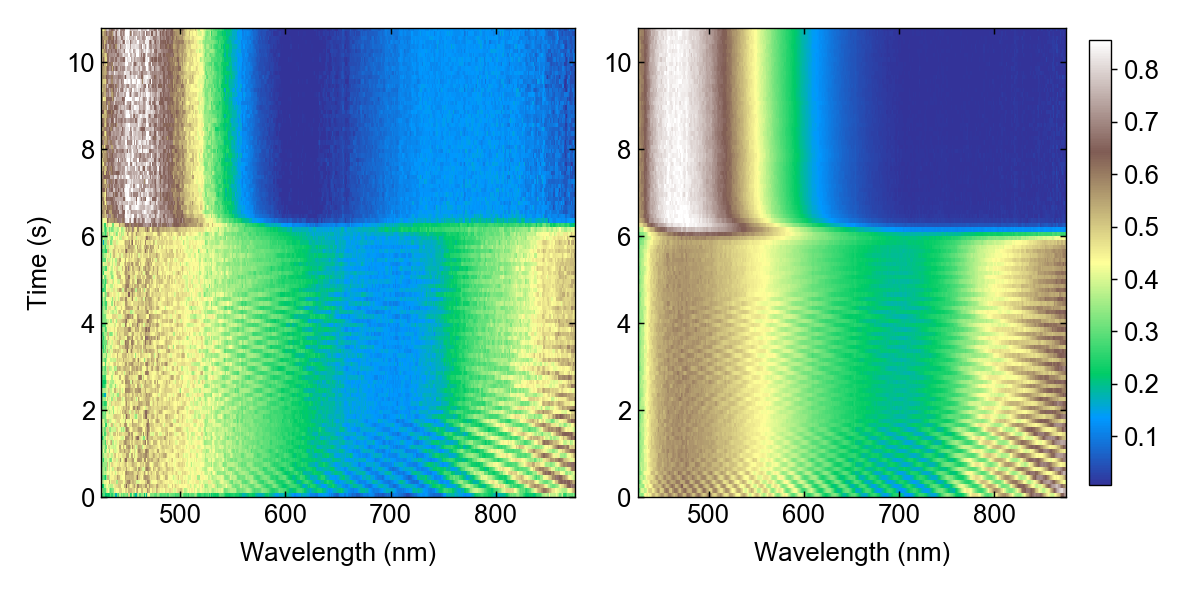

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [43]:
%matplotlib notebook

spec_start = 137; spec_stop = 245;

straight_crop = straight_array[spec_start:spec_stop,w_start_ind:w_stop_ind].clip(min=0.1,max=100)/100
kicked_crop = kicked_array[spec_start:spec_stop,w_start_ind:w_stop_ind].clip(min=0.1,max=100)/100

vmins, vmaxs = np.percentile(straight_crop, (2.5, 99.8))
vmink, vmaxk = np.percentile(kicked_crop, (2.5, 99.8))
extent_wli = [waves[w_start_ind], waves[w_stop_ind], 0, (spec_stop-spec_start)/10]

f1 = plt.figure(figsize=(9,4.5))
ax11 = plt.subplot(121)
plt.imshow(straight_crop,
                origin='lower', aspect='auto',
                vmin=vmins, vmax=vmaxs,
                interpolation='nearest',
                cmap='terrain',
                extent=extent_wli)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Time (s)')

ax12 = plt.subplot(122, sharey=ax11)
plt.imshow(kicked_crop,
                origin='lower', aspect='auto',
                vmin=vmink, vmax=vmaxk,
                interpolation='nearest',
                cmap='terrain',
                extent=extent_wli)
plt.xlabel('Wavelength (nm)')
plt.colorbar(fraction=0.047, pad=0.05).ax.tick_params(axis='y', direction='out')

uu_file = os.path.join(os.path.split(figfolder)[0],'{}_uu.png'.format(run_name))
plt.savefig(uu_file, dpi=300, bbox_inches='tight')

## Calculate anisotropy and plot

absorbance = -log(reflectance)

anisotropy = 1/2 * (N-1)/(N+1)
where N is the "dichroic ratio"

In [44]:
def get_anisotropy(straight_array,kicked_array):
    
    ratio_mat = -np.log(straight_array)/-np.log(kicked_array)
    aniso_mat = (ratio_mat-1)/(ratio_mat+1)
    
    return aniso_mat

<IPython.core.display.Javascript object>


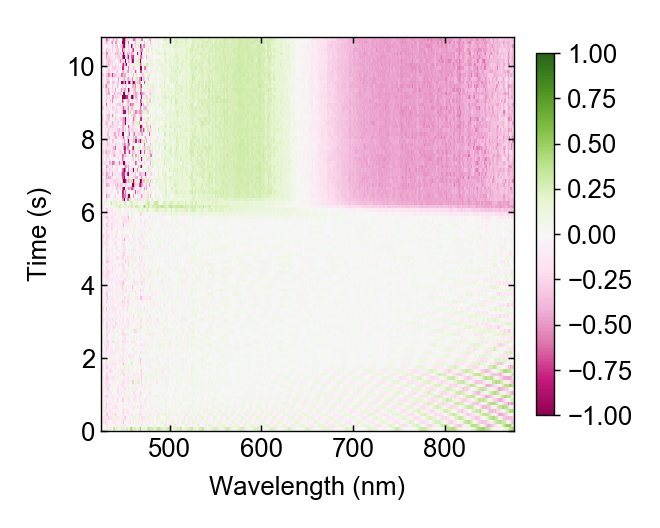

In [45]:
# aniso_mat = (-np.log(straight_crop)+np.log(kicked_crop))/(-np.log(straight_crop)-np.log(kicked_crop))
aniso_mat = get_anisotropy(straight_crop,kicked_crop)

plt.figure(figsize=(5,4))
plt.imshow(aniso_mat,
                origin='lower', aspect='auto',
                vmin=-1, vmax=1,
                interpolation='nearest',
                cmap='PiYG',
                extent=extent_wli)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Time (s)')
plt.colorbar(fraction=0.04, pad=0.05).ax.tick_params(axis='y', direction='out')

## We'd like to shift the spectra to eliminate the "anisotropy" from the early fringes, as these are likely due to the time dealy between straight/kicked file dumps

In [46]:
from scipy.ndimage.interpolation import shift
from scipy.optimize import minimize, minimize_scalar

def fringe_anisotropy(dt, straight, kicked, extent):
    
    # Given matrices straight and kicked, a time shift dt, and bounds for a slice where the fringes are,
    # perform a cubic spline interpolated shift of kicked along the time axis and sum up the anisotropy
    # within the slice
    
    shifted = shift(kicked,(dt,0))
    straight_fringes = straight[extent[0]:extent[1],extent[2]:extent[3]]
    shift_fringes = shifted[extent[0]:extent[1],extent[2]:extent[3]]
    
#     plt.figure()
#     plt.imshow(shift_fringes)
    
#     aniso_fringes = (-np.log(straight_fringes)+np.log(shift_fringes))/(-np.log(straight_fringes)-np.log(shift_fringes))
    aniso_fringes = get_anisotropy(straight_fringes,shift_fringes)
    print(np.abs(np.sum(np.sum(aniso_fringes))))
    
    return np.abs(np.sum(np.sum(aniso_fringes)))

In [47]:
init_params = 0

fringe_w_start = 600; fringe_w_stop = 870;
fw_start_ind = np.where(waves>fringe_w_start)[0][0]
fw_stop_ind = np.where(waves>fringe_w_stop)[0][0]

fringe_extent = [spec_start, spec_start+20, fw_start_ind, fw_stop_ind]
args = (straight_array, kicked_array, fringe_extent)
    
dt_shift = minimize(fringe_anisotropy, init_params,
                    args=args, method='COBYLA', tol=1e-6,
                    options={'disp':True})

print('shift kicked by {} rows'.format(dt_shift.x))

98.46526745531716
87.1457237578617
12.930214595314734
646.1122993741232
164.08913230522614
31.657139340402423
40.10989582283348
0.6013118276896741
10.970497118733668
5.2815863294010725
3.6138710989449407
0.8873005242003771
1.3500474755593501
0.22804971581726008
0.14447379698004426
0.5162575906569913
0.33045822953495474
0.051412223335365326
0.041695565027204395
0.13484955056482306
0.08826678424223289
0.018414286267507407
0.0048641048953470545
0.02813960818777872
0.016502217542615938
0.00095522216810906
0.006774729719381867
0.00386495338317161
0.0004996265185361892
0.0019544639248429974
0.0012270466317829687
0.0001359154043036881
0.0002277964146557565
5.477424949518195e-05
0.00024546409706971417
shift kicked by 1.9343529674072264 rows


<IPython.core.display.Javascript object>


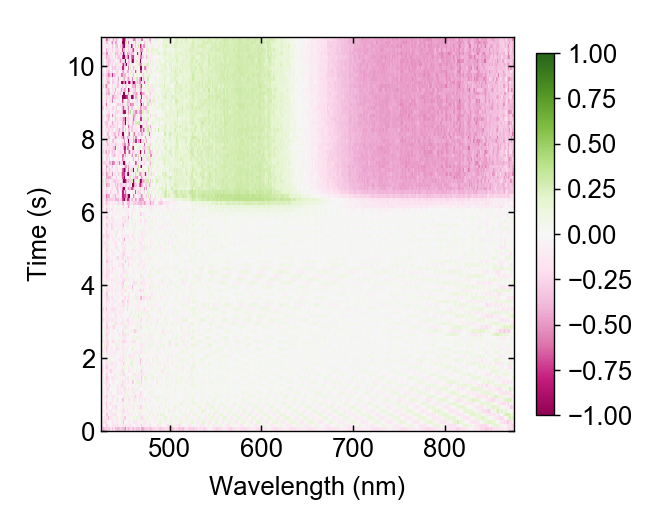

In [48]:
kicked_crop = shift(kicked_array,(dt_shift.x,0))[spec_start:spec_stop,w_start_ind:w_stop_ind].clip(min=0.1,max=100)/100

aniso_mat = get_anisotropy(straight_crop,kicked_crop)

plt.figure(figsize=(5,4))
plt.imshow(aniso_mat,
                origin='lower', aspect='auto',
                vmin=-1, vmax=1,
                interpolation='nearest',
                cmap='PiYG',
                extent=extent_wli)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Time (s)')
plt.colorbar(fraction=0.04, pad=0.05).ax.tick_params(axis='y', direction='out')

## Finally, plot xray and aniso side-by-side

In [ ]:
f2 = plt.figure(figsize=(9,4.5))

ax21 = plt.subplot(121)
plt.imshow(log_sect_crop,
            origin='lower', aspect='auto',
            vmin=vminx, vmax=vmaxx,
            interpolation='nearest',
            cmap='terrain',
            extent=extent_xray)

plt.xlabel(r'$q_{xy} \: (\AA^{-1})$')
plt.ylabel('Time (s)')

ax22 = plt.subplot(122, sharey=ax21)
plt.imshow(aniso_mat,
            origin='lower', aspect='auto',
            vmin=-1, vmax=1,
            interpolation='nearest',
            cmap='PiYG',
            extent=extent_wli)

plt.xlabel('Wavelength (nm)')
plt.colorbar(fraction=0.045, pad=0.05).ax.tick_params(axis='y', direction='out')
xu_file = os.path.join(os.path.split(figfolder)[0],'{}_xu.png'.format(run_name))
plt.savefig(xu_file, dpi=300, bbox_inches='tight')

In [ ]:
xu_file

## Plot all of the metrics over time

In [ ]:
%matplotlib notebook

t_start = 0
t_stop = 8 #df_mov['time'].max()
linew = 1
what = 'amplitude'
which = 'sigma'

gy=4
gx=1

plt.figure(figsize=(8,8))
plt.tight_layout()

plt.subplot(gy,gx,1)
pn1 = 0
plt.plot(df_mov['time'],[p[what].loc[pn1] for p in df_mov.peaks],
         linewidth=linew)
# plt.ylabel('{} {} (a.u.)'.format(df_mov.peaks.iloc[0]['name'].loc[pn1], what))
plt.xlim((t_start,t_stop))
plt.tick_params(labelbottom=False)
plt.tick_params(labeltop=True)
# plt.ylim((-0.3,10))


plt.subplot(gy,gx,2)
pn2 = 1
plt.plot(df_mov['time'],[p[what].loc[pn2] for p in df_mov.peaks],
         linewidth=linew)
# plt.ylabel('{} {} (a.u.)'.format(df_mov.peaks.iloc[0]['name'].loc[pn2], what))
plt.xlim((t_start,t_stop))
plt.tick_params(labelbottom=False)


plt.subplot(gy,gx,3)
plt.plot(df_mov['time'],[p[what].loc[0]/p[what].loc[1] for p in df_mov.peaks],
         linewidth=linew)
plt.plot(df_mov['time'],np.ones(df_mov['time'].shape)*6.43,'k--')
# plt.ylabel('(100)/(001) Ratio')
plt.xlim((t_start,t_stop))
plt.gca().set_yticks([0,2,4,6,8])
plt.ylim((-0.3,8.3))
plt.tick_params(labelbottom=False)


# plt.subplot(gy,gx,4)
# plt.plot(df_mov['time'],df_mov['Hermans'],
#          linewidth=linew)
# # plt.xlabel('Time after blade passage (s)')
# # plt.ylabel("H.O.F. (100)")
# plt.xlim((t_start,t_stop))
# # plt.ylim((-0.4,0.1))
# plt.tick_params(labelbottom=False)


plt.subplot(gy,gx,4)
plt.plot(np.array(range(aniso_mat.shape[0]))*uv_dt,
         aniso_mat[:,np.where(waves_crop>700)[0][0]],
         linewidth=linew)
plt.plot(df_mov['time'],np.zeros(df_mov['time'].shape),'k--')
# plt.ylabel("UV-Vis Anisotropy")
plt.xlim((t_start,t_stop))
# plt.ylim((-0.3,0.1))


allmet_file = os.path.join(os.path.split(figfolder)[0],'{}_all_metrics_wide.png'.format(run_name))
plt.savefig(allmet_file, dpi=300, bbox_inches='tight')

In [ ]:
allmet_file

## Generate spectra images for the movie

Previous cells must have been run for this to work.

Also add a 2-second buffer before blade passage

In [ ]:
%matplotlib notebook
xray_start_buf = int(xray_start - 2/xray_dt)

for ind,row in df.loc[df['movie_num']==main_movie].loc[df['shot_num'].between(xray_start_buf,xray_stop)].iterrows():

    data_file = row['fullpath']
    data_exp = row['exp_time']
    data = fabio.open(data_file).data
    data = np.flipud(data)
    
    pg = pygix.Transform(dist = sdd, poni1 = poni1, poni2 = poni2,
                     rot1 = rot1, rot2 = rot2, rot3 = rot3,
                     wavelength = wl, sample_orientation = sample_orientation,
                     incident_angle = incident_angle, tilt_angle = tilt_angle,
                     detector=detector)

    imgt, qxy, qz = pg.transform_reciprocal(data, method='lut', correctSolidAngle=True, unit='A', dark=darkscale)
    corrimg = imgt-np.min(imgt)+1
    logimg = np.log(corrimg)
    clim = np.percentile(logimg, (2.5, 99.8))
    
    figpath = os.path.join(figfolder,
                           'raw_waxs',
                           row['filename'][:-9]+'{0:04d}.png'.format(row['shot_num']-xray_start_buf))
    print(figpath)
    
    f = plt.figure(figsize=(5,5))
    f.patch.set_facecolor('w')
    f.patch.set_alpha(0)
    
    ppl.implot(logimg, qxy, qz,
               mode='rsma', cmap='terrain', newfig=False,
               clim=clim, xlim=(-0.2,2), ylim=(-0.05,2))
    ax=plt.gca()
    ax.set_facecolor('w')
    ax.set_alpha(0)
    plt.savefig(figpath)
    plt.close()

In [ ]:
figwild = figpath[:-8]+"%04d.png"
movieout = os.path.join(figfolder, "waxs_movie.mp4")

xray_cmd = """ffmpeg -framerate 5 -i "{}" -c:v libx264 -r 30 -pix_fmt yuv420p -vf "scale=720:720:force_original_aspect_ratio=decrease,pad=720:720:(ow-iw)/2:(oh-ih)/2" -y "{}" """.format(figwild,movieout)
# Run this to make the movie in command prompt
print("Paste into cmd:\n")
print(xray_cmd)
# !{xray_cmd}

In [ ]:
%matplotlib notebook

spec_start_buf = int(spec_start - 2/uv_dt)
straight_movie = straight_array[:,w_start_ind:w_stop_ind].clip(min=0.1,max=100)
kicked_shift = shift(kicked_array,(dt_shift.x,0))
kicked_movie = kicked_shift[:,w_start_ind:w_stop_ind].clip(min=0.1,max=100)

for i in range(spec_start_buf, spec_stop+1):
    
    uvfigpath = os.path.join(figfolder, 'raw_uv', 'refl_{0:04d}.png'.format(i-spec_start_buf))
    print(uvfigpath)
    
    f = plt.figure(figsize=(5,5))
    f.patch.set_facecolor('w')
    f.patch.set_alpha(0)
    
    plt.plot(waves_crop,straight_movie[i,:],
             waves_crop,kicked_movie[i,:])
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance (%)')
    
    ax_temp = plt.gca()
    ax_temp.set_ylim([0,100])
    ax_temp.set_facecolor('w')
    ax_temp.set_alpha(0)
    
    plt.savefig(uvfigpath, dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
uvfigwild = uvfigpath[:-8]+"%04d.png"
uvmovieout = os.path.join(figfolder, "uv_movie.mp4")

uv_cmd = """ffmpeg -framerate 10 -i "{}" -c:v libx264 -r 30 -pix_fmt yuv420p -vf "scale=720:720:force_original_aspect_ratio=decrease,pad=720:720:(ow-iw)/2:(oh-ih)/2" -y "{}" """.format(uvfigwild,uvmovieout)
# Run this to make the movie in command prompt
print("Paste into cmd:\n")
print(uv_cmd)
# !{uv_cmd}

In [ ]:
composite_out = os.path.join(os.path.split(figfolder)[0],'{}_movie.mp4'.format(run_name))

composite_cmd = """
ffmpeg -i "{}" -i "{}" -filter_complex "[0:v][1:v]hstack=inputs=2[v]" -map "[v]" -y "{}"
""".format(movieout,uvmovieout,composite_out)

print("Paste into cmd:\n")
print(composite_cmd)

# !{composite_cmd}

In [ ]:
import io
import base64
from IPython.display import HTML

video = io.open(composite_out, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

### Run peak fits over sectors starting from 88 back to 5 deg.
Initialize each fit from previous parameters

### Perform composite peak fits

In [ ]:
p100 = {'name': 'p100', 'set':1, 'cent': 2.3, 'min': 2.0, 'max': 3.0, 'sig': 0.1, 'amp': 1000, 'lb': 1.5, 'ub': 3.8}

p001 = {'name': 'p001', 'set':2, 'cent': 4.5, 'min': 4.0, 'max': 4.7, 'sig': 0.1, 'amp': 30, 'lb': 3.8, 'ub': 5.7}
p200 = {'name': 'p200', 'set':2, 'cent': 4.9, 'min': 4.7, 'max': 5.5, 'sig': 0.1, 'amp': 30, 'lb': 3.8, 'ub': 5.7}

p300 = {'name': 'p300', 'set':4, 'cent': 7.4, 'min': 7.0, 'max': 8.0, 'sig': 0.1, 'amp': 10, 'lb': 6.4, 'ub': 19.5}

p001a ={'name': 'p001a','set':4, 'cent': 8.8, 'min': 8.6, 'max': 9.0, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 19.5}
p002 = {'name': 'p002', 'set':4, 'cent': 9.5, 'min': 9.3, 'max': 9.8, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 11}
p400 = {'name': 'p400', 'set':4, 'cent': 9.9, 'min': 9.7, 'max': 10.3, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 11}

phalo ={'name': 'phalo', 'set':4, 'cent': 14, 'min': 12, 'max': 15, 'sig': 0.2, 'amp': 10, 'lb': 14, 'ub': 19.5}
p010 = {'name': 'p010', 'set':4, 'cent': 16.0, 'min': 15.2, 'max': 16.5, 'sig': 0.1, 'amp': 10, 'lb': 14, 'ub': 19.5}
p002a ={'name': 'p002a','set':4, 'cent': 17.7, 'min': 17.2, 'max': 18, 'sig': 0.1, 'amp': 10, 'lb': 14, 'ub': 19.5}

df = pd.DataFrame.from_dict([p100,p001,p200,p300,p001a,p400,phalo,p010,p002a]) #p002
df

In [ ]:
x = q_sect
y = int_sect
color_list = ['#3cb44b','#0082c8','#f58231','#911eb4','#800000','#000080','#808000']
f1 = plt.figure()
plt.semilogy(x, y, 'r-')

for i in df['set'].unique():
    
    df_peaks = df.loc[df.set==i]
    
    # Build bounded x and y vectors
    lb = df_peaks.iloc[0].lb
    ub = df_peaks.iloc[0].ub
    lb_ind = int(np.where(x>=lb)[0][0])
    ub_ind = int(np.where(x>=ub)[0][0])
    xb = x[lb_ind:ub_ind]
    yb = y[lb_ind:ub_ind]
    
    # Initialize Baseline model
    comp_mod = []
    
    if i not in [1,2]:
        lin_mod = ConstantModel(prefix='lin_')
        pars = lin_mod.make_params(c=yb.min())
        comp_mod.append(lin_mod)
    else:
        lin_mod = ExponentialModel(prefix='lin_')
        pars = lin_mod.guess(y,x=x)
        comp_mod.append(lin_mod)

    # Add peaks
    for index, peak in df_peaks.iterrows():
        prefix = peak['name']+'_'
        peak_temp  = VoigtModel(prefix=prefix)
        
        pars.update( peak_temp.make_params())
        pars[prefix+'center'].set(peak['cent'], min=peak['min'], max=peak['max'])
        pars[prefix+'sigma'].set(peak['sig'])
        pars[prefix+'amplitude'].set(peak['amp'], min=0)
        
        comp_mod.append(peak_temp)
    
    # Build composite model
    comp_mod = np.sum(comp_mod)
    out = comp_mod.fit(yb, pars, x=xb)
    params_dict=out.params.valuesdict()
    
    # Store peak features in original dataframe
    for peak, prop in [s.split('_') for s in list(params_dict.keys())]:
        df.loc[df.name==peak,prop] = params_dict[peak+'_'+prop]
    
    # Add peaks to plot
    comps = out.eval_components(x=xb)
    plt.semilogy(xb, out.eval(x=xb), '-', color = color_list[i])
    for c in comps:
        try:
            plt.semilogy(xb, comps[c], '--', color = color_list[i])
        except:
            const_eval = np.ones(xb.shape)*comps[c]
            plt.semilogy(xb, const_eval, '--', color = color_list[i])

# Show the plot
f1.axes[0].set_ylim( bottom=np.min(y)/10, top=np.max(y)*1.3 )
plt.show()

In [ ]:
df_pole = pd.DataFrame()

for d in range(88,6,-2):
    
    print(d)
    
    # Get I vs Q for angle d
    int_sect, q_sect = pg.profile_sector(data, npt=1000, chi_pos=d,
                                     chi_width=4, radial_range=(1.35, 20),
                                     correctSolidAngle=True,
                                     method='lut', dark=dark)
    
    # Run peak fits, initialized from previous fit's parameters
    x = q_sect
    y = int_sect
    
    df_prev = df
    
    for i in df['set'].unique():
        
        df_peaks = df_prev.loc[df.set==i]

        # Build bounded x and y vectors
        lb = df_peaks.iloc[0].lb
        ub = df_peaks.iloc[0].ub
        lb_ind = int(np.where(x>=lb)[0][0])
        ub_ind = int(np.where(x>=ub)[0][0])
        xb = x[lb_ind:ub_ind]
        yb = y[lb_ind:ub_ind]

        # Initialize Baseline model
        comp_mod = []

        if i not in [1,2]:
            lin_mod = ConstantModel(prefix='lin_')
            pars = lin_mod.make_params(c=yb.min())
            comp_mod.append(lin_mod)
        else:
            lin_mod = ExponentialModel(prefix='lin_')
            pars = lin_mod.guess(y,x=x)
            comp_mod.append(lin_mod)

        # Add peaks
        for index, peak in df_peaks.iterrows():
            prefix = peak['name']+'_'
            peak_temp  = VoigtModel(prefix=prefix)

            pars.update( peak_temp.make_params())
            pars[prefix+'center'].set(peak['center'], min=peak['min'], max=peak['max'])
            pars[prefix+'sigma'].set(peak['sigma'])
            pars[prefix+'amplitude'].set(peak['amplitude'], min=0)

            comp_mod.append(peak_temp)

        # Build composite model
        comp_mod = np.sum(comp_mod)
        out = comp_mod.fit(yb, pars, x=xb)
        params_dict=out.params.valuesdict()

        # Store peak features in original dataframe
        for peak, prop in [s.split('_') for s in list(params_dict.keys())]:
            df.loc[df.name==peak,prop] = params_dict[peak+'_'+prop]
        df['chi']=d

    # Store results in pole figure dataframe
    df_pole = df_pole.append(df)

In [ ]:
df_pole[df_pole.name=='p200']

In [ ]:
pole_list

In [ ]:
h200 = [dfp['height'].loc[2] for dfp in df_pole['peaks'].tolist()]
plt.figure()
plt.plot(df_pole['chi'].tolist(),h200)

### Compute d-spacing, Herman's Orientation

In [ ]:
df['d-space']=2*np.pi / df['center'] * 10
df

In [ ]:
def Hermans(ii, chi):
    sin_chi = np.sin(np.deg2rad(chi))
    cos2chi = np.cos(np.deg2rad(chi)) ** 2
    return np.sum(ii * cos2chi * sin_chi) / np.sum(ii * sin_chi)

def interp_nans(data):
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    return data

### Chi-profile, radially integrated, for Herman's calculation

In [ ]:
p200_q = float(df['center'][df['name']=='p200'])

cake, chi = pg.profile_chi(data, npt=200,
                           radial_pos=p200_q, radial_width=.3,
                           chi_range=(-88,88),
                           correctSolidAngle=True,
                           method='lut', dark=dark)

ppl.plot(chi,np.abs(interp_nans(cake) * np.sin(np.deg2rad(chi))),mode='chi')
print('Hermans Orientation Factor: ', Hermans(interp_nans(cake),chi))

### q-chi map, just because it's possible

In [ ]:
intensity, q_abs, chi = pg.transform_polar(data,
                                           npt=(2000, 400), q_range=(0,20),
                                           correctSolidAngle=True,
                                           method='splitpix', dark=dark)

ppl.implot(intensity, q_abs, chi, mode='polar', cmap='terrain', clim=np.percentile(intensity,(0.1,99.5)))

### Generate cropped, processed spectrum for all files

Previous cells must have been run for this to work.

In [ ]:
for ind,row in df.iterrows():
    
    data = fabio.open(row['fullpath']).data
    data = np.flipud(data)
    
    if row['exp_time'] == 30:
        dark = np.flipud(fabio.open(dark30file).data)
    else: 
        dark = np.flipud(fabio.open(dark90file).data)
    
    pg = pygix.Transform(dist = sdd, poni1 = poni1, poni2 = poni2,
                         rot1 = rot1, rot2 = rot2, rot3 = rot3,
                         wavelength = wl, sample_orientation = sample_orientation,
                         incident_angle = incident_angle, tilt_angle = tilt_angle,
                         detector=detector)

    imgt, qxy, qz = pg.transform_reciprocal(data, method='lut', correctSolidAngle=True, unit='A', dark=dark)
    logimg = np.log(imgt+1)
    
    figfile = (row['fullpath'].split('.')[:-1][0]+'.png').replace('data','figures')
    print(figfile)
    clim = np.percentile(logimg[logimg>0], (3, 99.99))
    ppl.implot(logimg,qxy,qz,mode='rsma',cmap='terrain',clim=clim,xlim=(-.6,2),ylim=(-.05,2),show=False,filename=figfile)
    plt.close()

### Write a master function to automate analysis

In [ ]:
def analyze_n22(dfrow):
    
    # Open file, get data and dark spectra
    data_file = dfrow['fullpath']
    print(dfrow['filename'])
    data = fabio.open(data_file).data
    data = np.flipud(data)

    if dfrow['exp_time'] == 30:
        dark = np.flipud(fabio.open(dark30file).data)
    else: 
        dark = np.flipud(fabio.open(dark90file).data)
        
        
    # Setup detector and transform
    ### Detector pixel size
    det_pix = [73.242e-6, 73.242e-6]
    detector = pyFAI.detectors.Detector(det_pix[0], det_pix[1])

    ### Wavelength
    wl = 0.976254e-10

    ### Center-pixel and sample-to-detector distance
    centerx =  1532.42
    centery = data.shape[0]-3034.23   # This is because I had to flip it upside-down
    sdd = 0.339316

    ### Beamcenter from sample view in meters from lower left of detector
    poni1 = centery * det_pix[1]; poni2 = centerx * det_pix[0]

    ### detector rotations from sample view
    rot1 = deldel /180 * np.pi # move detector to right, in-plane angle# in radians
    rot2 = 0.0    /180 * np.pi # move detector down, out-of-plane angle
    rot3 = 0.0    /180 * np.pi # clockwise rotation

    ### Orientations and Angles
    sample_orientation = 1    # 1 is horizontal, 2 is vertical
    incident_angle = dfrow['theta']     # indicent angle in deg
    tilt_angle = 0            # tilt angle of sample in deg (misalignment in "chi")
    
    ### Initialize the transform
    pg = pygix.Transform(dist = sdd, poni1 = poni1, poni2 = poni2,
                     rot1 = rot1, rot2 = rot2, rot3 = rot3,
                     wavelength = wl, sample_orientation = sample_orientation,
                     incident_angle = incident_angle, tilt_angle = tilt_angle,
                     detector=detector)
    
    # in-plane profile for analysis
    int_in, q_in = pg.profile_ip_box(data, npt=1000, op_pos=0,
                                 op_width=1, ip_range=(1.35, 20),
                                 correctSolidAngle=True,
                                 method='lut', dark=dark)
    
    # Fitting parameters
    p100 = {'name': 'p100', 'set':1, 'cent': 2.3, 'min': 2.2, 'max': 2.6, 'sig': 0.1, 'amp': 1000, 'lb': 1.5, 'ub': 3.8}

    p001 = {'name': 'p001', 'set':2, 'cent': 4.5, 'min': 4.3, 'max': 4.7, 'sig': 0.1, 'amp': 30, 'lb': 3.8, 'ub': 5.7}
    p200 = {'name': 'p200', 'set':2, 'cent': 4.9, 'min': 4.7, 'max': 5.0, 'sig': 0.1, 'amp': 30, 'lb': 3.8, 'ub': 5.7}

    p300 = {'name': 'p300', 'set':3, 'cent': 7.4, 'min': 7.0, 'max': 8.0, 'sig': 0.1, 'amp': 10, 'lb': 6.4, 'ub': 8.3}

    p001a ={'name': 'p001a','set':4, 'cent': 8.8, 'min': 8.6, 'max': 9.0, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 11}
    p002 = {'name': 'p002', 'set':4, 'cent': 9.5, 'min': 9.3, 'max': 9.8, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 11}
    p400 = {'name': 'p400', 'set':4, 'cent': 9.9, 'min': 9.7, 'max': 10.3, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 11}

    p002a ={'name': 'p002a','set':5, 'cent': 17.7, 'min': 17.2, 'max': 18, 'sig': 0.1, 'amp': 10, 'lb': 16.7, 'ub': 18.7}

    df = pd.DataFrame.from_dict([p100,p001,p200,p300,p001a,p002,p400,p002a])
    
    # Perform Peak Fits
    x = q_in
    y = int_in

    for i in df['set'].unique():

        df_peaks = df.loc[df.set==i]

        # Build bounded x and y vectors
        lb = df_peaks.iloc[0].lb
        ub = df_peaks.iloc[0].ub
        lb_ind = int(np.where(x>=lb)[0][0])
        ub_ind = int(np.where(x>=ub)[0][0])
        xb = x[lb_ind:ub_ind]
        yb = y[lb_ind:ub_ind]

        # Initialize Baseline model
        comp_mod = []
        lin_mod = LinearModel(prefix='lin_')
        pars = lin_mod.make_params(intercept=yb.min(), slope=0)
        comp_mod.append(lin_mod)

        # Add peaks
        for index, peak in df_peaks.iterrows():
            prefix = peak['name']+'_'
            peak_temp  = VoigtModel(prefix=prefix)

            pars.update( peak_temp.make_params())
            pars[prefix+'center'].set(peak['cent'], min=peak['min'], max=peak['max'])
            pars[prefix+'sigma'].set(peak['sig'])
            pars[prefix+'amplitude'].set(peak['amp'], min=0)

            comp_mod.append(peak_temp)

        # Build composite model
        comp_mod = np.sum(comp_mod)
        out = comp_mod.fit(yb, pars, x=xb)
        params_dict=out.params.valuesdict()

        # Store peak features in original dataframe
        for peak, prop in [s.split('_') for s in list(params_dict.keys())]:
            df.loc[df.name==peak,prop] = params_dict[peak+'_'+prop]
            
    # Store results of peak fits in dfrow
    dfrow['peak_fits'] = df
    
    
    # Get Herman's Orientation and store
    p200_q = float(df['center'][df['name']=='p200'])
    
    cake, chi = pg.profile_chi(data, npt=200,
                               radial_pos=p200_q, radial_width=.3,
                               chi_range=(3,88),
                               correctSolidAngle=True,
                               method='lut', dark=dark)
    
    dfrow['Hermans'] = Hermans(interp_nans(cake),chi)
    
    return dfrow

In [ ]:
df_test = df.iloc[0]
df_test

In [ ]:
res = analyze_n22(df_test)

In [ ]:
df_res = pd.DataFrame()
for i,row in df.iterrows():
    try:
        df_res = df_res.append(analyze_n22(row))
    except:
        pass
    
df_res

In [ ]:
df_res[['filename','solvent','speed','grooves','sample_phi','theta','Hermans']]

In [ ]:
df_res = 

In [ ]:
df_res.to_csv(path_or_buf='n22_waxs_results.csv')

In [ ]:
df_res.to_pickle('n22_waxs_pickle')

In [ ]:
df_new = pd.read_pickle('n22_waxs_pickle')
df_new

In [ ]:
df_new